In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='MAINUT5068DCQGJ9',output_format='pandas')
# Get json object with the intraday data and another with  the call's metadata



# get all available daily data (Netflix)
mydata, meta_data = ts.get_daily('NFLX',outputsize='full')

Text(0.5,0,'Date')

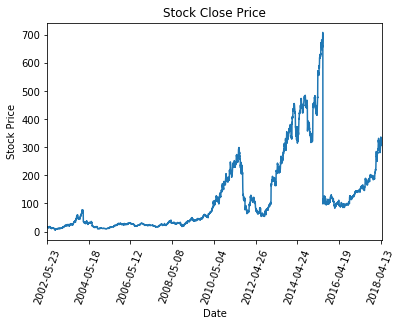

In [4]:
#data.head()
mydata['4. close'].plot()
plt.xticks(rotation=70)
plt.title('Stock Close Price')
plt.ylabel('Stock Price')
plt.xlabel('Date')

In [5]:
dataset = mydata['4. close'].loc['2017-04-26':'2018-04-26'].values
dataset = dataset.astype('|S6')

In [6]:
preproc = input("What Preprocessing do you like? None (N), Differencing (D) or Moving Average (M): ")
print("You chose: ", preproc)

What Preprocessing do you like? None (N), Differencing (D) or Moving Average (M): N
You chose:  N


In [7]:
if preproc == 'D':
    dataset = np.diff(dataset)
    print('Differencing applied')
elif preproc == 'M':
    cumsum = np.cumsum(np.insert(dataset, 0, 0)) 
    dataset = (cumsum[5:] - cumsum[:-5]) / float(5)
    print('Moving Average applied')
else:
    dataset = dataset
    print('no preprocessing applied')

no preprocessing applied


In [8]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

169 84


In [9]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [10]:
look_back = input("How many days in the past do you want to use as feature vector? ")
print("You chose: ", look_back)

How many days in the past do you want to use as feature vector? 5
You chose:  5


In [11]:
look_back = int(look_back)

In [12]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

/Users/beate/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype |S6 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30),max_iter=10000)
mlp.fit(trainX,trainY)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [15]:
trainPredict = mlp.predict(trainX)
testPredict = mlp.predict(testX)

In [16]:
trainPredict = trainPredict.astype('float')
trainY = trainY.astype('float')
testY = testY.astype('float')
testPredict = testPredict.astype('float')

In [17]:
trainScore = sqrt(mean_squared_error(trainY, trainPredict))
testScore = sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.00 RMSE
Test Score: 88.91 RMSE


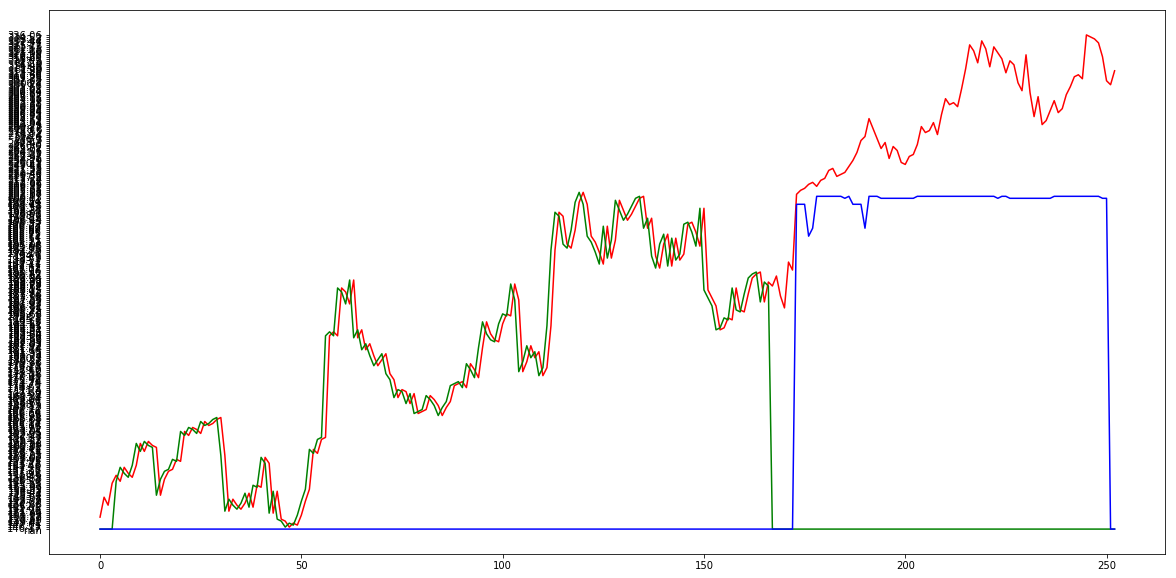

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1] = trainPredict[:]

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset)-2] = testPredict[:]

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(dataset,'r')
plt.plot(trainPredictPlot,'g')
plt.plot(testPredictPlot,'b')
plt.show()